In [1]:
%load_ext autoreload
%autoreload 2

In [27]:
import torch
import torch.nn as nn

In [86]:
class Network(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(2, 1)

    def forward(self,x):
        x = torch.sigmoid(self.fc1(x))
        return x
    
model = Network()

x = torch.randn([3,2], requires_grad=True)
y = model(x)
print(y.shape)
print(y)


# compute first order deriv
dy_xy = torch.autograd.grad(y, x, torch.ones_like(y), 
                            create_graph=True,
                            retain_graph=True)[0]
dy_x, dy_y = dy_xy.split(1,-1)
# compute secord order deriv
dy_x_xy = torch.autograd.grad(dy_x, x, torch.ones_like(dy_x), 
                              create_graph=True,
                              retain_graph=True)[0]
dy_xx, dy_xy = dy_x_xy.split(1,-1)
dy_y_xy = torch.autograd.grad(dy_y, x, torch.ones_like(dy_y),
                              create_graph=True,
                              retain_graph=True)[0]
dy_yx, dy_yy = dy_y_xy.split(1,-1)

# gather results in a matrix Bx2x2 in the form of Div-free kernel
# K1 = torch.cat([-dy_yy, dy_xy], dim=-1)[...,None]
# K2 = torch.cat([dy_yx, -dy_xx], dim=-1)[...,None]
# K = torch.cat([K1, K2], dim=-1)
# the columns of K make a divergence-free field
u =  dy_xy - dy_yy
v =  dy_xy - dy_xx



# check if it is divergence free
du_xy = torch.autograd.grad(u, x, torch.ones_like(u), create_graph=True)[0]
dv_xy = torch.autograd.grad(v, x, torch.ones_like(v), create_graph=True)[0]
# last two columns are x and y
div_u_xy = du_xy[...,0] + dv_xy[...,1]


print(du_xy[:3,:])
print(dv_xy[:3,:])
print(div_u_xy)

torch.Size([3, 1])
tensor([[0.5719],
        [0.4903],
        [0.4270]], grad_fn=<SigmoidBackward>)
tensor([[0.0041, 0.0082],
        [0.0045, 0.0089],
        [0.0041, 0.0082]], grad_fn=<SliceBackward>)
tensor([[-0.0021, -0.0041],
        [-0.0023, -0.0045],
        [-0.0021, -0.0041]], grad_fn=<SliceBackward>)
tensor([-4.6566e-10, -4.6566e-10, -4.6566e-10], grad_fn=<AddBackward0>)


In [224]:
class Network(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(2,  10)
        self.fc2 = nn.Linear(10, 20)
        self.fc3 = nn.Linear(20, 1)

    def forward(self,x):
        x = torch.sigmoid(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        return x
    
    def compute_u_x(self, x):
        self.u_x = torch.autograd.functional.jacobian(self, x, create_graph=True)
        self.u_x = torch.squeeze(self.u_x)
        return self.u_x
    
    def compute_u_xx(self, x):
        self.u_xx = torch.autograd.functional.jacobian(self.compute_u_x, x)
        self.u_xx = torch.squeeze(self.u_xx)
        return self.u_xx

    def compute_u_x_compact(self, x):
        self.u_x = torch.autograd.functional.jacobian(self, x, create_graph=True)
        self.u_x = torch.squeeze(self.u_x)
        B = x.shape[0]
        return self.u_x[range(B),range(B),:]
    
    def compute_u_xx_compact(self, x):
        self.u_xx = torch.autograd.functional.jacobian(self.compute_u_x, x)
        self.u_xx = torch.squeeze(self.u_xx)
        B = x.shape[0]
        return self.u_xx[range(B),range(B),:,range(B),:]
    
    def compute_u_xx_compact2(self, x):
        self.u_xx = torch.autograd.functional.jacobian(self.compute_u_x_compact, x)
        self.u_xx = torch.squeeze(self.u_xx)
        B = x.shape[0]
        return self.u_xx[range(B),:,range(B),:]
    
    
model = Network()

x = torch.randn([3,2], requires_grad=True)
y_hat = model(x)
print(y_hat)

print('Compute u_x')
u_x = model.compute_u_x(x)
print(u_x[0,0,:])

print('Compute u_xx')
u_xx = model.compute_u_xx(x)
print(u_xx[0,0,:,0,:])

print('Compute u_x')
u_x = model.compute_u_x_compact(x)
print(u_x[0,:])

print('Compute u_xx')
u_xx = model.compute_u_xx_compact(x)
print(u_xx[0,:,:])

print('Compute u_xx')
u_xx = model.compute_u_xx_compact2(x)
print(u_xx.shape)
print(u_xx[0,:,:])

tensor([[0.5473],
        [0.5446],
        [0.5473]], grad_fn=<SigmoidBackward>)
Compute u_x
tensor([-0.0003,  0.0023], grad_fn=<SliceBackward>)
Compute u_xx
tensor([[-0.0001,  0.0002],
        [ 0.0002, -0.0002]])
Compute u_x
tensor([-0.0003,  0.0023], grad_fn=<SliceBackward>)
Compute u_xx
tensor([[-0.0001,  0.0002],
        [ 0.0002, -0.0002]])
Compute u_xx
torch.Size([3, 2, 2])
tensor([[-0.0001,  0.0002],
        [ 0.0002, -0.0002]])


In [231]:
class Network(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(2,  10)
        self.fc2 = nn.Linear(10, 20)
        self.fc3 = nn.Linear(20, 2)

    def forward(self,x):
        x = torch.sigmoid(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        return x
    
    def compute_u_x(self, x):
        self.u_x = torch.autograd.functional.jacobian(self, x, create_graph=True)
        self.u_x = torch.squeeze(self.u_x)
        B = x.shape[0]
        return self.u_x[range(B),:,range(B),:]
    
    def compute_u_xx(self, x):
        self.u_xx = torch.autograd.functional.jacobian(self.compute_u_x, x)
        self.u_xx = torch.squeeze(self.u_xx)
        B = x.shape[0]
        return self.u_xx[range(B),:,:,range(B),:]
    
model = Network()

x = torch.randn([3,2], requires_grad=True)
y_hat = model(x)
print(y_hat)

print('Compute u_x')
u_x = model.compute_u_x(x)
print(u_x)

print('Compute u_xx')
u_xx = model.compute_u_xx(x)
print(u_xx)

tensor([[0.4262, 0.4615],
        [0.4247, 0.4558],
        [0.4224, 0.4546]], grad_fn=<SigmoidBackward>)
Compute u_x
tensor([[[0.0015, 0.0008],
         [0.0033, 0.0002]],

        [[0.0017, 0.0012],
         [0.0034, 0.0007]],

        [[0.0018, 0.0012],
         [0.0048, 0.0019]]], grad_fn=<IndexBackward>)
Compute u_xx
tensor([[[[-3.8038e-04, -4.2309e-04],
          [-4.2309e-04, -4.6558e-04]],

         [[-9.5410e-04, -8.2380e-04],
          [-8.2380e-04, -8.8329e-04]]],


        [[[-4.7000e-04, -4.3359e-04],
          [-4.3359e-04, -1.3300e-04]],

         [[-6.4040e-04, -9.5066e-04],
          [-9.5066e-04, -7.3898e-04]]],


        [[[ 2.8370e-04,  3.4179e-04],
          [ 3.4179e-04,  8.2533e-05]],

         [[ 1.9804e-04,  1.3016e-04],
          [ 1.3016e-04, -5.7954e-06]]]])


In [40]:

from turboflow.models.divfree_rff import DivFree

class Network(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(2, 10)
        self.fc2 = nn.Linear(10, 1)

    def forward(self,x):
        x = torch.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        return x

model = Network()
    
x = torch.randn(5,2).requires_grad_(True)
a = torch.randn(5,2)


y = model(x)
div = DivFree()
pred = div(y, x)

u, v = torch.split(pred,1,-1)
du_xy = torch.autograd.grad(u, x, torch.ones_like(u), create_graph=True)[0]       
dv_xy = torch.autograd.grad(v, x, torch.ones_like(v), create_graph=True)[0]
# last two columns are x and y
div_u_xy = du_xy[:,0] + dv_xy[:,1]

print('Output dimension')
print(du_xy.shape)
print(dv_xy.shape)

print(du_xy)
print(dv_xy)
print(div_u_xy)

print('Output')
print(pred)

torch.Size([5, 1])
Output dimension
torch.Size([5, 2])
torch.Size([5, 2])
tensor([[-7.6681e-08, -1.8185e-07],
        [ 3.7526e-05,  4.0189e-05],
        [-8.8986e-05, -7.0605e-05],
        [-1.3843e-04, -1.1057e-04],
        [-6.2141e-04, -2.4820e-04]], grad_fn=<MmBackward>)
tensor([[ 3.2334e-08,  7.6681e-08],
        [-3.5040e-05, -3.7526e-05],
        [ 1.1215e-04,  8.8987e-05],
        [ 1.7331e-04,  1.3843e-04],
        [ 1.5558e-03,  6.2141e-04]], grad_fn=<MmBackward>)
tensor([ 2.1316e-13,  2.1828e-11,  3.6380e-11,  5.8208e-11, -5.2387e-10],
       grad_fn=<AddBackward0>)
Output
tensor([[-2.7997e-06,  1.1806e-06],
        [-1.6292e-04,  1.5213e-04],
        [ 2.6432e-04, -3.3313e-04],
        [ 4.0475e-04, -5.0672e-04],
        [ 3.7424e-04, -9.3697e-04]], grad_fn=<TanhBackward>)


In [39]:
from turboflow.dataloaders import Turbo2D_simple
from torch.utils.data import Dataset, DataLoader


use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

path_to_data = '../data/2021-Turb2D_velocities.npy'
trainset = Turbo2D_simple(path_to_data, device, ds=4, img=42)
trainloader = DataLoader(trainset, batch_size=10000, shuffle=False)

Dataset Turbo2D, img # 42
(64, 64, 2)
(64, 64, 2)
Original size 64
Y shape (64, 64, 2)
Y min, max: -2.365612 2.941536
after normalization, Y min, max: -0.8042097733972999 1.0


In [46]:
from turboflow.models.divfree_rff import DivFreeRFFNet
dfrff = DivFreeRFFNet('DivFree', [2*256] + 3*[128] + [1], 256, 10)
print(dfrff)
x = torch.randn(3,2)

pred = dfrff(x)
print(pred)

u, v = torch.split(pred,1,-1)
du_xy = torch.autograd.grad(u, x, torch.ones_like(u), create_graph=True)[0]       
dv_xy = torch.autograd.grad(v, x, torch.ones_like(v), create_graph=True)[0]
# last two columns are x and y
div_u_xy = du_xy[...,0] + dv_xy[...,1]
print(du_xy[:,0])
print(dv_xy[:,1])
print(div_u_xy)

DivFreeRFFNet(
  (rff): Fourier()
  (mlp): MLP(
    (network): Sequential(
      (0): Sequential(
        (0): Linear(in_features=512, out_features=128, bias=True)
        (1): Tanh()
      )
      (1): Sequential(
        (0): Linear(in_features=128, out_features=128, bias=True)
        (1): Tanh()
      )
      (2): Sequential(
        (0): Linear(in_features=128, out_features=128, bias=True)
        (1): Tanh()
      )
      (3): Linear(in_features=128, out_features=1, bias=True)
    )
  )
  (div): DivFree()
)
tensor([[-4.0040,  2.3454],
        [ 1.3909,  0.5860],
        [ 1.5642,  1.1272]], grad_fn=<CatBackward>)
tensor([ 324.7842,  472.1459, -526.4653], grad_fn=<SelectBackward>)
tensor([-324.7842, -472.1458,  526.4653], grad_fn=<SelectBackward>)
tensor([0.0000e+00, 3.0518e-05, 0.0000e+00], grad_fn=<AddBackward0>)


In [47]:
dfrff.to(device)
dfrff.fit(trainloader, epochs=2000)

Epoch: 1, Loss: 13.928529
  Div: 0.0033628493547439575
Epoch: 100, Loss: 0.086860
  Div: 0.0008570530917495489
Epoch: 200, Loss: 0.054751
  Div: -0.0012979418970644474
Epoch: 300, Loss: 0.041044
  Div: 0.0006228527054190636
Epoch: 400, Loss: 0.032961
  Div: 1.3232696801424026e-05
Epoch: 500, Loss: 0.027320
  Div: -0.0003066047211177647
Epoch: 600, Loss: 0.023008
  Div: 0.0009300913661718369
Epoch: 700, Loss: 0.019530
  Div: -0.0006944458000361919
Epoch: 800, Loss: 0.016629
  Div: 0.001192792085930705
Epoch: 900, Loss: 0.014160
  Div: 0.0003663033712655306
Epoch: 1000, Loss: 0.012033
  Div: 0.0009692551102489233
Epoch: 1100, Loss: 0.010196
  Div: 0.0002629724331200123
Epoch: 1200, Loss: 0.008614
  Div: 0.0006847670301795006
Epoch: 1300, Loss: 0.007259
  Div: -0.00021152198314666748
Epoch: 1400, Loss: 0.006109
  Div: 0.0015301615931093693
Epoch: 1500, Loss: 0.005138
  Div: 0.0018816270167008042
Epoch: 1600, Loss: 0.004322
  Div: -0.0006707006832584739
Epoch: 1700, Loss: 0.003637
  Div: -

(16384, 2)
tensor([-12.9187,  14.0359, -27.6836,  ...,  -9.8673, -48.3117,   6.2328],
       device='cuda:0', grad_fn=<SelectBackward>)
tensor([ 12.9187, -14.0358,  27.6836,  ...,   9.8673,  48.3117,  -6.2328],
       device='cuda:0', grad_fn=<SelectBackward>)
tensor([ 1.5259e-05,  4.7684e-06, -7.6294e-06,  ..., -2.1935e-05,
         1.5259e-05,  1.9550e-05], device='cuda:0', grad_fn=<AddBackward0>)


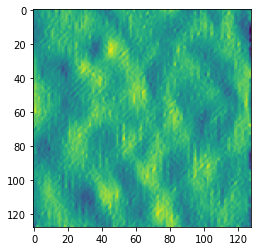

In [48]:
# TEST
import numpy as np
import matplotlib.pyplot as plt

ngrid = 128
coords = np.linspace(0, 1, ngrid)
coords = np.stack(np.meshgrid(coords, coords), -1) # X x Y x 2
tmp = coords[:,:,0].copy()
coords[:,:,0] = coords[:,:,1]
coords[:,:,1] = tmp
coords = coords.reshape(ngrid*ngrid,2)
print(coords.shape)

x = torch.from_numpy(coords).float().contiguous().to(device)

dfrff.eval().to(device)
pred = dfrff(x)

ypred = pred.cpu().detach().numpy().squeeze()

u, v = torch.split(pred,1,-1)
du_xy = torch.autograd.grad(u, x, torch.ones_like(u), create_graph=True)[0]       
dv_xy = torch.autograd.grad(v, x, torch.ones_like(v), create_graph=True)[0]
# last two columns are x and y
div_u_xy = du_xy[...,0] + dv_xy[...,1]
print(du_xy[:,0])
print(dv_xy[:,1])
print(div_u_xy)

plt.imshow(ypred.reshape(ngrid,ngrid,2)[:,:,0])
plt.show()

In [ ]:
c = dfrff.rbf.centers.detach().cpu().numpy()

plt.scatter(c[:,0],c[:,1])